# Airbnb Data - EDA and data visualization

This notebook performs basic EDA and data visualization (data viz) on a cleansed open-source Airbnb dataset from Kaggle. The goal is to extract meaningful insights for customers and air bnb users.

The dataset includes listing-level information such as location, price, availability, and review activity.

🔗 Source of raw, uncleansed data: [Airbnb Open Data on Kaggle](https://www.kaggle.com/datasets/arianazmoudeh/airbnbopendata)

Note: This is a personal data science project for educational purposes. To reproduce the results, please download the dataset directly from Kaggle and run it through my data cleansing notebook which you can find here: [Click here to view GitHub cleansing repo](https://github.com/mg-ds-portfolio/prj_open_airbnb_data_cleanse.git)

In [33]:
# Import packages.
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [34]:
# Configure chart displays and float display.

# Allow in-line plotting.
%matplotlib inline

# Set plot style.
plt.style.use("seaborn-v0_8-whitegrid")

In [35]:
# import raw data and take a copy to work on.
df_raw = pd.read_csv("/home/mark/data_viz_practice/data/airbnb_open_data_cleaned.csv")
df = df_raw.copy()

In [36]:
# Inspect data.
df.head()

,id,neighbourhood_group,neighbourhood,lat,long,instant_bookable,cancellation_policy,room_type,construction_year,price,service_fee,minimum_nights,number_of_reviews,last_review,reviews_per_month,review_rate_number,calculated_host_listings_count,availability_365
0,1001254,brooklyn,kensington,40.65,-73.97,False,strict,private room,"2,020.00",966.00,193.00,10.00,9.00,2021-10-19,0.21,4.00,6.00,286.00
1,1002102,manhattan,midtown,40.75,-73.98,False,moderate,entire home/apt,"2,007.00",142.00,28.00,30.00,45.00,2022-05-21,0.38,4.00,2.00,228.00
2,1002403,manhattan,harlem,40.81,-73.94,True,flexible,private room,"2,005.00",620.00,124.00,3.00,0.00,NaN,0.00,5.00,1.00,352.00
3,1002755,brooklyn,clinton hill,40.69,-73.96,True,moderate,entire home/apt,"2,005.00",368.00,74.00,30.00,270.00,2019-07-05,4.64,4.00,1.00,322.00
4,1003689,manhattan,east harlem,40.80,-73.94,False,moderate,entire home/apt,"2,009.00",204.00,41.00,10.00,9.00,2018-11-19,0.10,3.00,1.00,289.00


In [37]:
# Check data types and number of unique values.
data_types = df.dtypes
count_nas = df.isna().sum()
count_unique = df.nunique()

pd.concat([data_types, count_nas, count_unique], axis = 1).rename(columns={0: "data_type", 1: "na_count", 2: "num_unique_values"})

,data_type,na_count,num_unique_values
id,int64,0,99812
neighbourhood_group,object,0,5
neighbourhood,object,0,224
lat,float64,0,21846
long,float64,0,17643
instant_bookable,bool,0,2
cancellation_policy,object,0,3
room_type,object,0,4
construction_year,float64,0,20
price,float64,0,1151


Observations:
- The only column with NAs is last_review. All others have been cleansed.
- Data types broadly align with content (int/float for numbers, object for strings)

Actions:
- Convert data types

In [38]:
# Convert columns to correct data type.

category_type_cols = ["neighbourhood_group", "instant_bookable", "construction_year", "cancellation_policy", "room_type"]
numeric_type_cols = ["id", "lat", "long", "price", "service_fee", "minimum_nights", "number_of_reviews", "reviews_per_month", "review_rate_number", "calculated_host_listings_count", "availability_365"]
string_type_cols = ["neighbourhood"]
datetime_type_cols = ["last_review"]

for col in category_type_cols:
    df[col] = df[col].astype("category")

for col in numeric_type_cols:
    df[col] = pd.to_numeric(df[col])

for col in string_type_cols:
    df[col] = df[col].astype("string")

for col in datetime_type_cols:
    df[col] = pd.to_datetime(df[col])

print("Conversion check:")
print("----------")
print(f"Category columns: {len(category_type_cols)}")
print(f"Numeric columns: {len(numeric_type_cols)}")
print(f"String columns: {len(string_type_cols)}")
print(f"Datetime columns: {len(datetime_type_cols)}")
print("----------")
print(f"Total # cols converted: {len(category_type_cols) + len(numeric_type_cols) + len(string_type_cols) + len(datetime_type_cols)}")

print(f"df width: {len(df.columns)}")

print("\n")

print(df.dtypes)

Conversion check:
----------
Category columns: 5
Numeric columns: 11
String columns: 1
Datetime columns: 1
----------
Total # cols converted: 18
df width: 18


id                                         int64
neighbourhood_group                     category
neighbourhood                     string[python]
lat                                      float64
long                                     float64
instant_bookable                        category
cancellation_policy                     category
room_type                               category
construction_year                       category
price                                    float64
service_fee                              float64
minimum_nights                           float64
number_of_reviews                        float64
last_review                       datetime64[ns]
reviews_per_month                        float64
review_rate_number                       float64
calculated_host_listings_count           float64
availab

Notes on conversion:
- review_rate_number left as float so we can perform numerical calculations on data

What useful information can we extract from this information? Let's look at it from 2 different perspectives - that of a customer, and that of an airbnb owner.

Customer POV questions:
- Where are the properties located? How many options do we have in each neighbourhood_group?
- If I want a certain type of room, which area should I focus on?
- Where are the best rated properties?
- Does a high number of reviews translate to a higher rating?
- Where will I find the best deal (highest rating for the lowest price)?

Owner questions:
- Could I justify a price increase by changing features of my listings - instant_bookable status, cancellation_policy type etc.?
- Are my service fees in line with other owners?
- Should I try to get more reviews, i.e. are properties with more reviews charging a higher price?

To create graphs in Matplotlib or Seaborn, follow the same 5 steps:
1. Prepare the data
2. Create the figure and axes
3. Create the chart
4. Format chart elements
5. Show the chart

In [ ]:
# How many properties do we have in each neighbourhood_group?

# Step 1. Prepare the data

properties_per_ngroup = df["neighbourhood_group"].value_counts()
properties_per_ngroup

neighbourhood_group
manhattan        42588
brooklyn         40737
queens           12925
bronx             2632
staten island      930
Name: count, dtype: int64

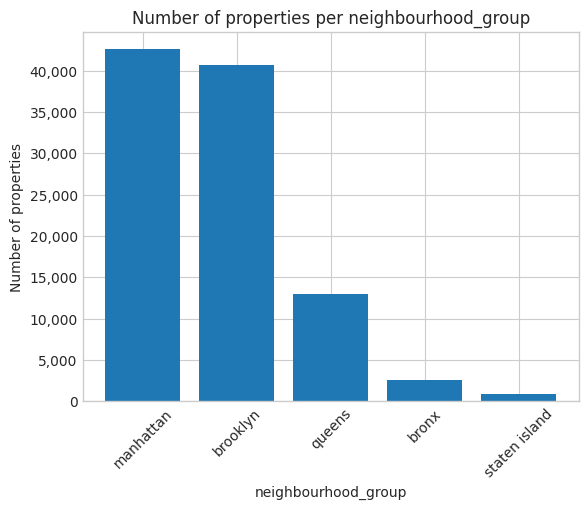

In [41]:
# Step 2. Create the figure and axes
fig, ax = plt.subplots()

# Step 3. Create the chart
ax.bar(properties_per_ngroup.index, properties_per_ngroup.values)

# Step 4. Format chart elements
ax.set_title("Number of properties per neighbourhood_group")
ax.set_xlabel("neighbourhood_group")
ax.set_ylabel("Number of properties")
ax.tick_params(axis = "x", rotation = 45)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x):,}"))

# Step 5. Show plot
plt.show()